# **INITIALIZATION**

# Importing Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from gensim.models import Word2Vec

In [2]:
# Reading the data
df = pd.read_excel("/kaggle/input/online-retail/Online Retail.xlsx")

# Dataset

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
print(f"Number of rows in the dataset is {df.shape[0]} and columns is {df.shape[1]}")

Number of rows in the dataset is 541909 and columns is 8


In [5]:
print(f"Datatypes of the columns :\n{df.dtypes}")

Datatypes of the columns :
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


# **DATA CLEANING**

In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

> ****We're missing more than 130,000 values in the CustomerID column, which is about 25% of all the data. If we just get rid of these and carry on, our analysis and predictions might not be very good. Each customer uses the same InvoiceNo every time they buy something in a certain period. So, I'm giving new IDs to customers who don't have one yet. I'm checking the InvoiceNo to see if it belongs to the same customer or a different one. If it matches, they'll get the same ID, and if not, they'll get a new one.****

**Assigning new values to the empty customerid**

In [7]:
unique_customer_ids = df['CustomerID'].dropna().unique()  # Droping NaN values

new_customer_id = int(unique_customer_ids.max()) + 1 
prev_invoice_no = None  # Storing the previous InvoiceNo
for index, row in df.iterrows():
    if pd.isnull(row['CustomerID']):  # Check if CustomerID is missing
        if row['InvoiceNo'] == prev_invoice_no:
            df.at[index, 'CustomerID'] = df.loc[index - 1, 'CustomerID']  # Assign CustomerID of same invoiceno
        else:
            new_customer_id += 1
            df.at[index, 'CustomerID'] = new_customer_id  # Create a new CustomerID
    
    prev_invoice_no = row['InvoiceNo']  # Update the previous InvoiceNo



**Replacing the missing the missing values in description using most frequent descriptions**

In [8]:
df['Description'] = df['Description'].fillna(df['Description'].mode()[0])

In [9]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

**Removing Duplicate Rows**

In [10]:
df.drop_duplicates(inplace=True)

**Removing Negative Values in Quantity and UnitPrice columns**

In [11]:
negative_qty = df[df['Quantity'] < 0]
negative_unitprice= df[df['UnitPrice']<0]
print(f"\nNumber of records with negative Quantity: {negative_qty.shape[0]}")
print(f"\nNumber of records with negative Unit Price: {negative_unitprice.shape[0]}")

# Remove rows with values less than zero
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice']> 0]


Number of records with negative Quantity: 10587

Number of records with negative Unit Price: 2


In [12]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [13]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['Date'] = df['InvoiceDate'].dt.date
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Weekday'] = df['InvoiceDate'].dt.weekday
df['Date'] = pd.to_datetime(df['Date'])

In [14]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,Date,Year,Month,Day,Weekday
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010,12,1,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010,12,1,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010,12,1,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010,12,1,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010,12,1,2


# **EXPLORATION**

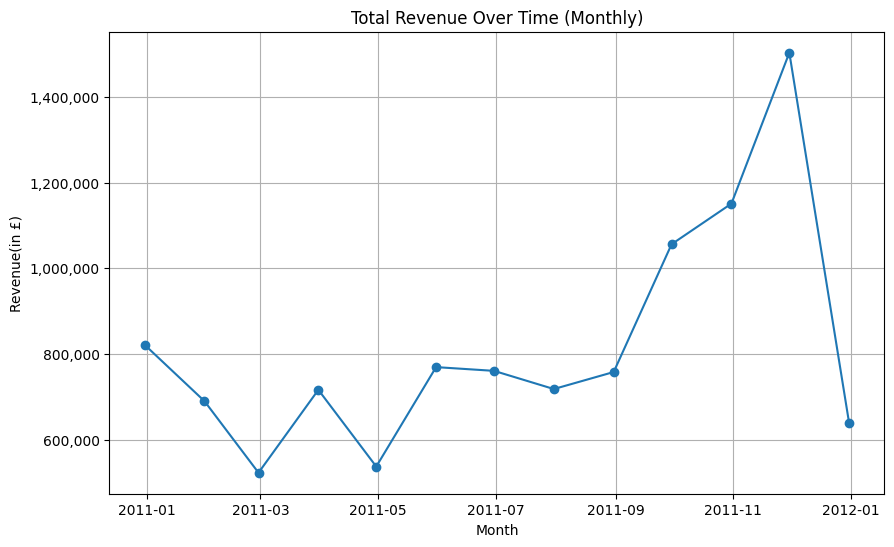

In [15]:
monthly_revenue = df.resample('ME', on='InvoiceDate')['TotalAmount'].sum()

plt.figure(figsize=(10, 6))
plt.plot(monthly_revenue, marker='o', linestyle='-')
plt.title('Total Revenue Over Time (Monthly)')
plt.xlabel('Month')
plt.ylabel('Revenue(in £)')
plt.grid(True)

formatter = StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()


In [16]:
aggregated_data = df.groupby(['Date','Year', 'Month', 'Day','Weekday']).agg({
    'TotalAmount': 'sum',
}).reset_index()

In [17]:
aggregated_data

,Date,Year,Month,Day,Weekday,TotalAmount
0,2010-12-01,2010,12,1,2,58776.79
1,2010-12-02,2010,12,2,3,47629.42
2,2010-12-03,2010,12,3,4,46898.63
3,2010-12-05,2010,12,5,6,31364.63
4,2010-12-06,2010,12,6,0,54624.15
...,...,...,...,...,...,...
300,2011-12-05,2011,12,5,0,88620.84
301,2011-12-06,2011,12,6,1,56558.83
302,2011-12-07,2011,12,7,2,75315.55
303,2011-12-08,2011,12,8,3,82371.55


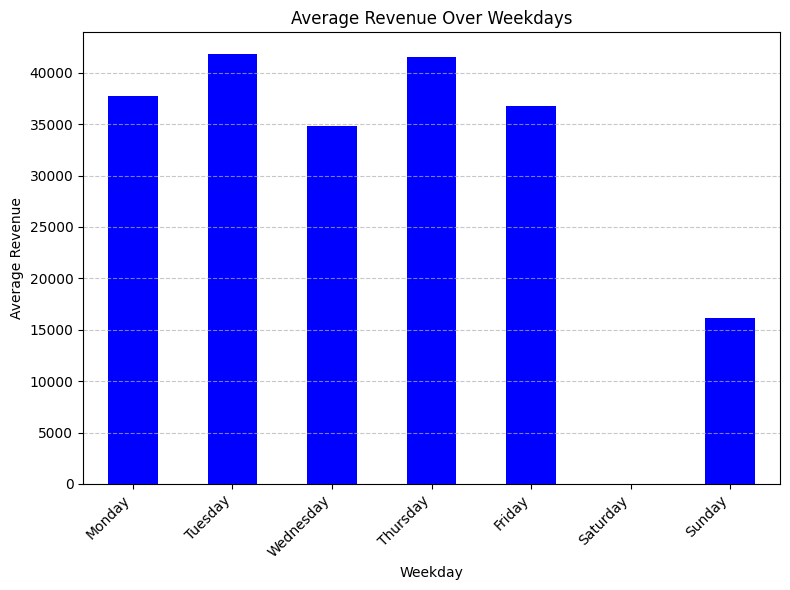

In [18]:
weekday_avg_spend = aggregated_data.groupby('Weekday')['TotalAmount'].mean()
weekday_avg_spend = weekday_avg_spend.reindex(range(7), fill_value=0)

plt.figure(figsize=(8, 6))
weekday_avg_spend.plot(kind='bar', color='blue')
plt.title('Average Revenue Over Weekdays')
plt.xlabel('Weekday')
plt.ylabel('Average Revenue')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

>**From this graph it's so obvious that, the retail store is closed during Saturdays or nobody actually buys anything on Saturdays. And Sunday is recording having the lowest revenue in a day. All other weekdays except Saturday and Sunday, the average revenue is above 30000£. Tuesday and Thursday is having the highest average revenue which is above 40000£.**

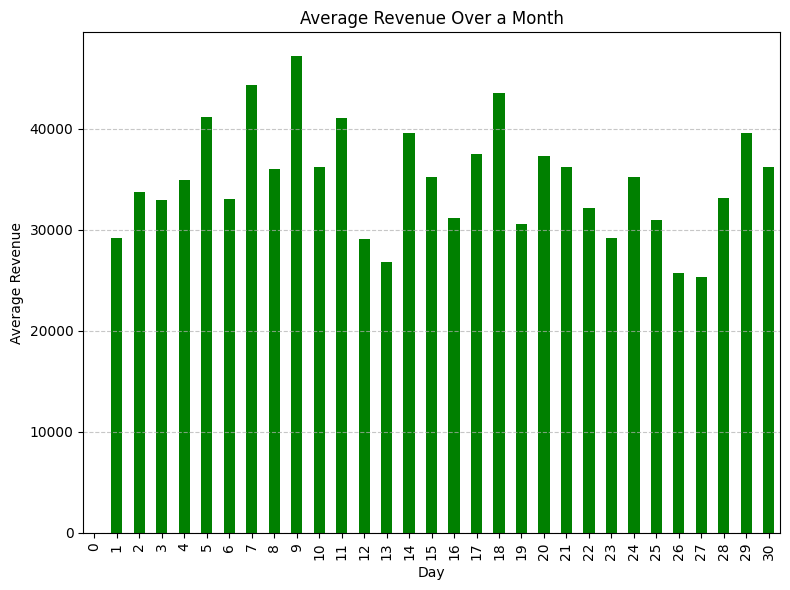

In [19]:
daily_avg_spend = aggregated_data.groupby('Day')['TotalAmount'].mean()
daily_avg_spend = daily_avg_spend.reindex(range(31), fill_value=0)

plt.figure(figsize=(8, 6))
daily_avg_spend.plot(kind='bar', color='green')
plt.title('Average Revenue Over a Month')
plt.xlabel('Day')
plt.ylabel('Average Revenue')
#plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **HOLIDAY SALES**

**Our data is from December 1st 2010 to December 9 2011.These are the public holidays observed in UK during that period.**

Christmas Day - 25th December 2010

Boxing Day - 26th December 2010

New Year's Day - 1st January 2011

Good Friday - 22nd April 2011

Easter Monday - 25th April 2011

Early May Bank Holiday - 2nd May 2011

Spring Bank Holiday - 30th May 2011

Summer Bank Holiday - 29th August 2011

**Sales During Christmas New Year Holiday Week**

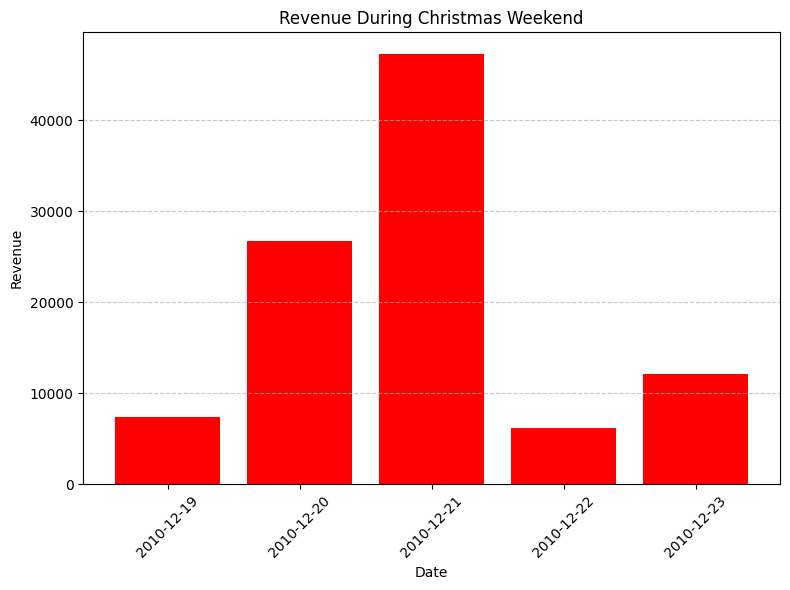

In [20]:
holiday = aggregated_data[aggregated_data['Date'].between('2010-12-19', '2011-01-01')]
plt.figure(figsize=(8, 6))
plt.bar(holiday['Date'], holiday['TotalAmount'], color='red')
plt.title('Revenue During Christmas Weekend')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


> **From this graph it's clear that the shop was closed from 24th December 2010 to 1st January 2011. The total sales for this period was actually below the average sales for a week. Every day except on 21st December was having below average sales.**

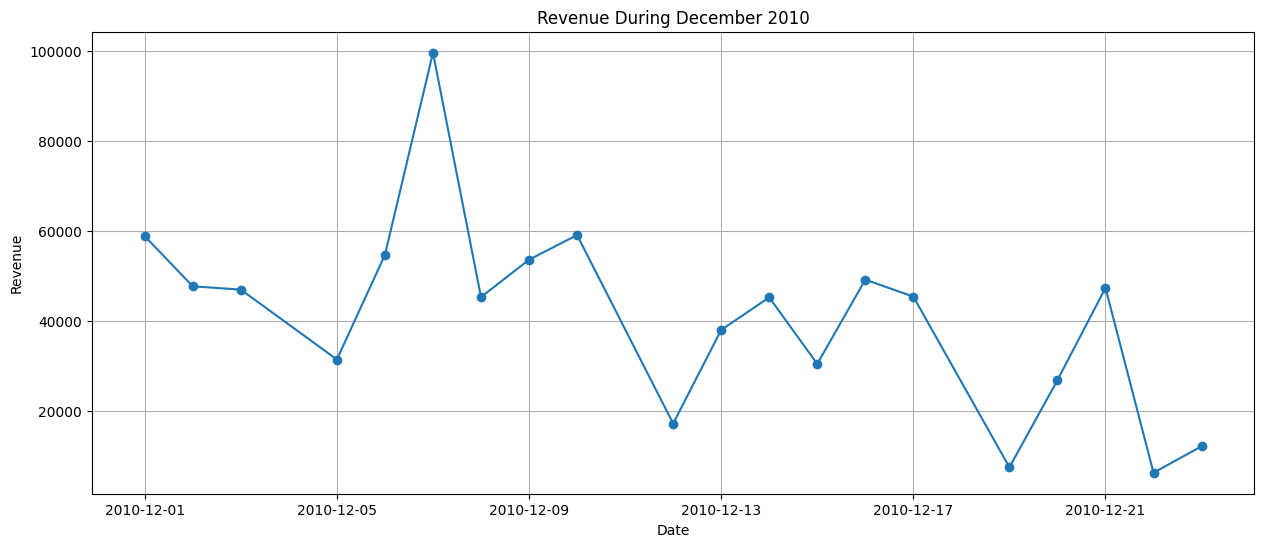

In [21]:
monthly = aggregated_data[aggregated_data['Date'].between('2010-12-01', '2011-01-01')]

plt.figure(figsize=(15, 6))
plt.plot(monthly['Date'], monthly['TotalAmount'], marker='o', linestyle='-')
plt.title('Revenue During December 2010')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

> **When we analyse the sales during the December 2010, the sales goes to a high after the first week and then it goes down to average sales. From the sales during Christmas graph we have seen that the sales were pretty below average. But here we can see a clear peak performance of sales coming after the first week. It shows that the delivery time of products must have been about 2 weeks in average that people bought stuff before weeks in advance so that they don't have to worry about getting producs delayed.**

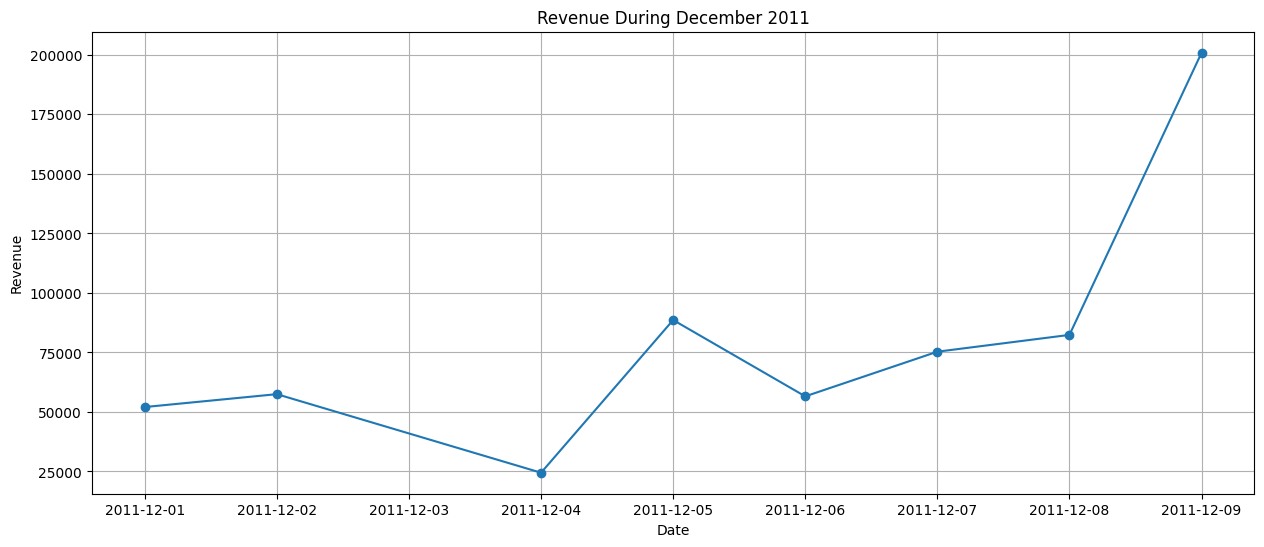

In [22]:
monthly = aggregated_data[aggregated_data['Date'].between('2011-12-01', '2011-12-09')]

plt.figure(figsize=(15, 6))
plt.plot(monthly['Date'], monthly['TotalAmount'], marker='o', linestyle='-')
plt.title('Revenue During December 2011')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

> **We can see the same signs here in December 2011 too. Unfortunately we only have datas till 9th December. Sales is going high than average just into midweek and is peaked at 200K sales on 9th December.**

**Sales during Easter week**

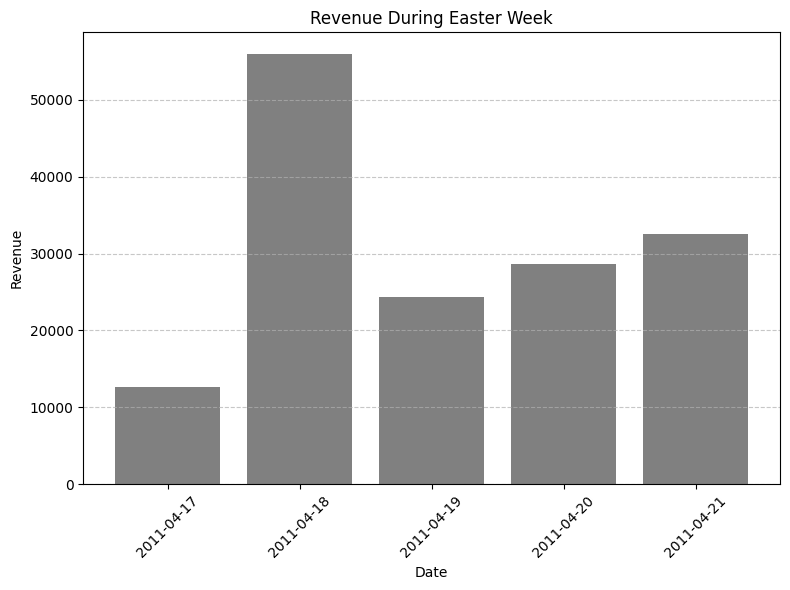

In [23]:
holiday = aggregated_data[aggregated_data['Date'].between('2011-04-17', '2011-04-25')]

plt.figure(figsize=(8, 6))
plt.bar(holiday['Date'], holiday['TotalAmount'], color='gray')
plt.title('Revenue During Easter Week')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


>**We had a great sales on Monday 18th April 2011 for above 50K. Apart from that the other days perform average sales.**

**Summer & Winter Season Sales**

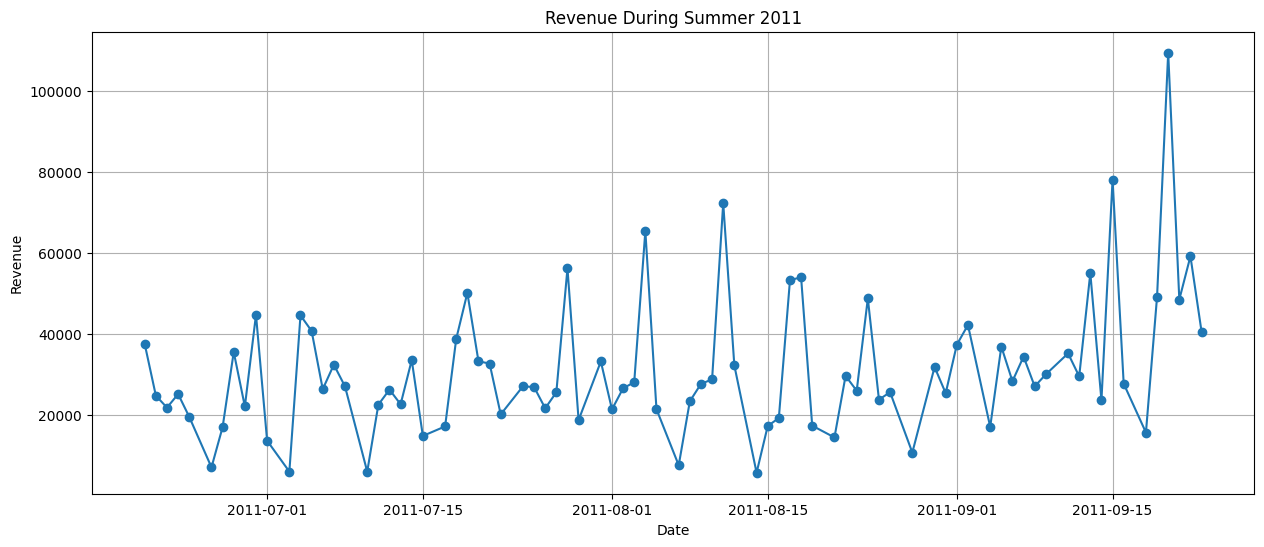

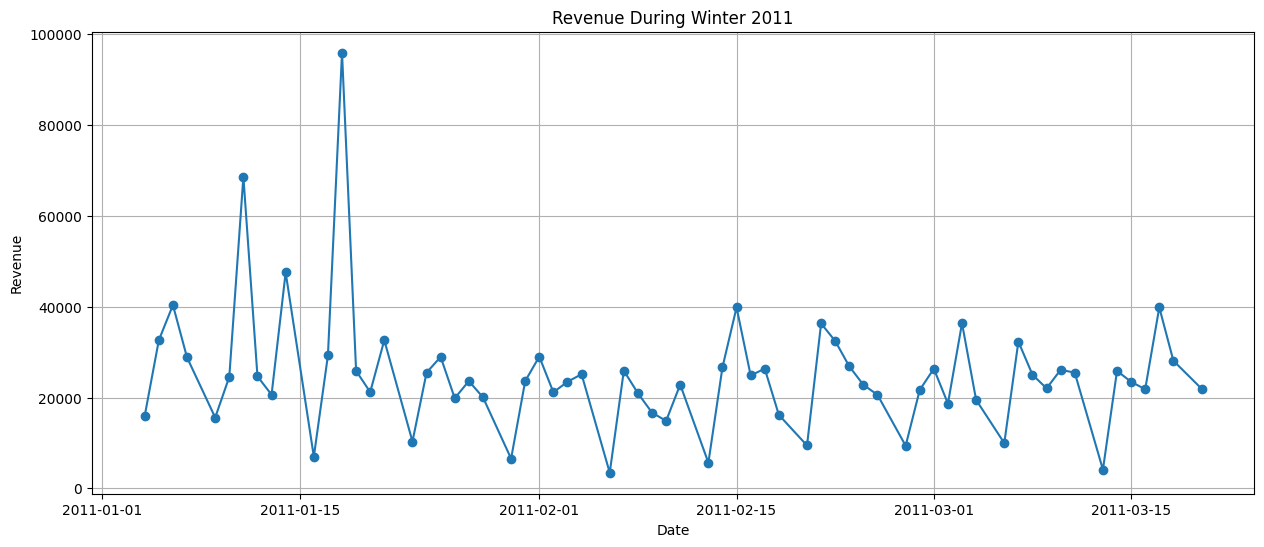

In [24]:
monthly = aggregated_data[aggregated_data['Date'].between('2011-06-20', '2011-09-23')]

plt.figure(figsize=(15, 6))
plt.plot(monthly['Date'], monthly['TotalAmount'], marker='o', linestyle='-')
plt.title('Revenue During Summer 2011')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

monthly = aggregated_data[aggregated_data['Date'].between('2011-01-01', '2011-03-20')]

plt.figure(figsize=(15, 6))
plt.plot(monthly['Date'], monthly['TotalAmount'], marker='o', linestyle='-')
plt.title('Revenue During Winter 2011')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

>**Apart from the start of the year winter season doesn't have much spike in sales. It is mostly below average. While summer season had a consistent of average to above average sales with sales peaking towards end of the season.**

**Top Selling Products**

In [25]:
top_selling = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_selling

Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        78033
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54951
JUMBO BAG RED RETROSPOT               48371
WHITE HANGING HEART T-LIGHT HOLDER    37872
POPCORN HOLDER                        36749
PACK OF 72 RETROSPOT CAKE CASES       36396
ASSORTED COLOUR BIRD ORNAMENT         36362
RABBIT NIGHT LIGHT                    30739
MINI PAINT SET VINTAGE                26633
Name: Quantity, dtype: int64

**Most Profitable categories**

In [26]:
most_profitable = df.groupby('Description')['UnitPrice'].sum().sort_values(ascending=False).head(10)
most_profitable

Description
DOTCOM POSTAGE                        206248.77
Manual                                 74101.28
POSTAGE                                34992.23
REGENCY CAKESTAND 3 TIER               28065.76
AMAZON FEE                             13761.09
Adjust bad debt                        11062.06
PARTY BUNTING                           9850.68
SET OF 3 CAKE TINS PANTRY DESIGN        8120.53
CREAM SWEETHEART MINI CHEST             7497.46
WHITE HANGING HEART T-LIGHT HOLDER      7437.57
Name: UnitPrice, dtype: float64

# **Customer Metrics**

In [27]:
customer_df = df.groupby('CustomerID').agg(
    AveragePurchaseFrequency=('InvoiceDate', lambda x: x.diff().mean()),  # Average time between purchases
    AverageSpendPerVisit=('UnitPrice', 'mean'),  # Average spend per visit
    TotalSpend=('UnitPrice', 'sum')  # Total spend per customer
).reset_index()

customer_df.head(5)

,CustomerID,AveragePurchaseFrequency,AverageSpendPerVisit,TotalSpend
0,12346.0,NaT,1.040000,1.04
1,12347.0,2 days 00:24:10.276243093,2.644011,481.21
2,12348.0,9 days 10:12:08,5.764839,178.71
3,12349.0,0 days 00:00:00,8.289041,605.10
4,12350.0,0 days 00:00:00,3.841176,65.30


# **Product Metrics**

In [28]:
product_df = df.groupby('Description').agg(
    StockTurnRate=('Quantity', 'mean'),  # Stock turn rate (average quantity sold per period)
    AveragePrice=('UnitPrice', 'mean'),
    SalesVolume=('Quantity', 'sum')
).reset_index()


product_df.head(10)

,Description,StockTurnRate,AveragePrice,SalesVolume
0,4 PURPLE FLOCK DINNER CANDLES,3.641026,2.450513,142
1,50'S CHRISTMAS GIFT BAG LARGE,14.844961,1.426589,1915
2,DOLLY GIRL BEAKER,13.926136,1.506420,2451
3,I LOVE LONDON MINI BACKPACK,4.459770,4.616667,388
4,I LOVE LONDON MINI RUCKSACK,1.000000,4.150000,1
5,NINE DRAWER OFFICE TIDY,1.757576,16.090606,58
6,OVAL WALL MIRROR DIAMANTE,1.512821,10.774936,236
7,RED SPOT GIFT BAG LARGE,16.631068,1.377184,1713
8,SET 2 TEA TOWELS I LOVE LONDON,10.156934,3.557847,2783
9,SPACEBOY BABY GIFT SET,2.706522,15.913424,498


# **FORECASTING**

> **The data we have consists of only 12 months. So seasonality effect is not valid here. Because of the small data we have, I'm using Machine Learning models for forecasting purpose.**

In [29]:
data_sorted = df.sort_values(by='InvoiceDate')
country_encoder = OneHotEncoder()
country_encoded = country_encoder.fit_transform(data_sorted[['Country']]).toarray()

country_encoded_df = pd.DataFrame(country_encoded, columns=country_encoder.get_feature_names_out(['Country']))

data_sorted = pd.concat([data_sorted, country_encoded_df], axis=1)

In [30]:
data_sorted.isnull().sum()

InvoiceNo                       16616
StockCode                       16616
Description                     16616
Quantity                        16616
InvoiceDate                     16616
UnitPrice                       16616
CustomerID                      16616
Country                         16616
TotalAmount                     16616
Date                            16616
Year                            16616
Month                           16616
Day                             16616
Weekday                         16616
Country_Australia               16616
Country_Austria                 16616
Country_Bahrain                 16616
Country_Belgium                 16616
Country_Brazil                  16616
Country_Canada                  16616
Country_Channel Islands         16616
Country_Cyprus                  16616
Country_Czech Republic          16616
Country_Denmark                 16616
Country_EIRE                    16616
Country_European Community      16616
Country_Finl

In [31]:
# Drop rows with NaN values
data_sorted.dropna(inplace=True)

In [32]:
X = data_sorted.drop(['TotalAmount', 'InvoiceNo', 'Description', 'InvoiceDate','Date','StockCode', 'Country'], axis=1)
y = data_sorted['TotalAmount']

train_size = int(0.8 * len(data_sorted))  # 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

**Using Gridsearch to find the best parameters for the model**

In [33]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_regressor = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_rf_model = grid_search.best_estimator_

train_score = best_rf_model.score(X_train, y_train)
test_score = best_rf_model.score(X_test, y_test)

print("Train R^2 Score:", train_score)
print("Test R^2 Score:", test_score)

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Train R^2 Score: 0.9117258639762632
Test R^2 Score: 0.9914038847528889


**Random Forest**

In [34]:
rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_train, y_train)

train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)

print("Train R^2 Score:", train_score)
print("Test R^2 Score:", test_score)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')


Train R^2 Score: 0.9117258639762632
Test R^2 Score: 0.9914038847528889
Root Mean Squared Error (RMSE): 6.209527891944454


In [35]:
# Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}

/tmp/ipykernel_18/754067383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Date'] = pd.to_datetime(X_test[['Year', 'Month', 'Day']])


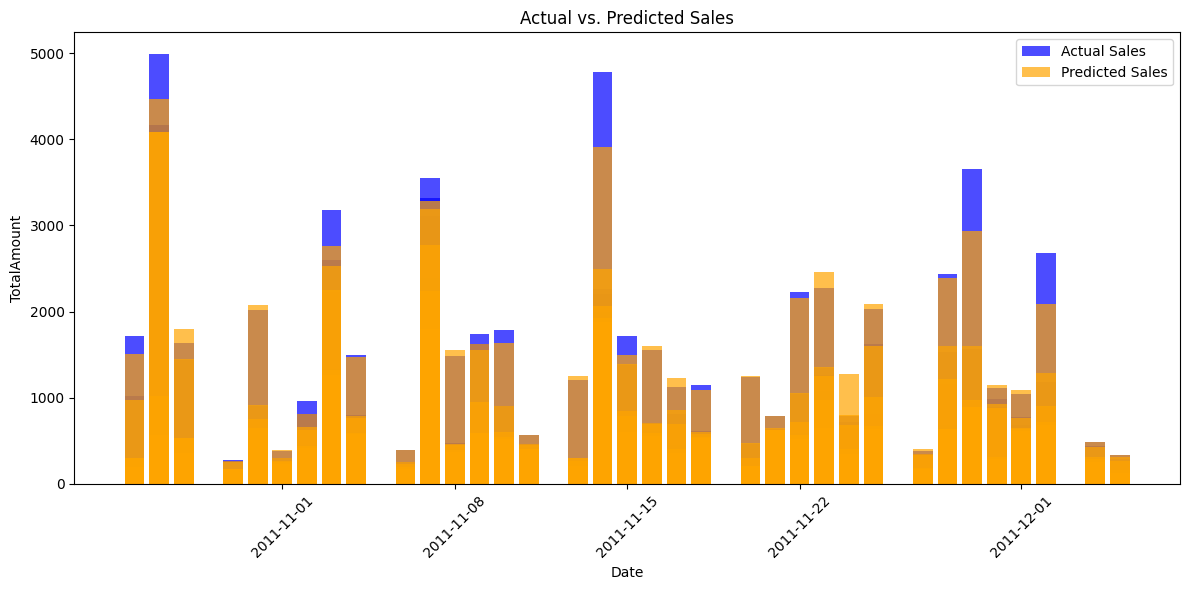

In [36]:
X_test['Date'] = pd.to_datetime(X_test[['Year', 'Month', 'Day']])

plt.figure(figsize=(12, 6))
plt.bar(X_test['Date'], y_test, label='Actual Sales', color='blue', alpha=0.7)
plt.bar(X_test['Date'], y_pred, label='Predicted Sales', color='orange', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('TotalAmount')
plt.title('Actual vs. Predicted Sales')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()